Image segmentation

Image segmentation is the process of partitioning an image into multiple different regions (or segments). The goal is to change the representation of the image into an easier and more meaningful image.

It is an important step in image processing, as real world images doesn't always contain only one object that we wanna classify. For instance, for self driving cars, the image would contain the road, cars, pedestrians, etc. So we may need to use segmentation here to separate objects and analyze each object individually (i.e image classification) to check what it is.

K-Means clustering is unsupervised machine learning algorithm that aims to partition N observations into K clusters in which each observation belongs to the cluster with the nearest mean. A cluster refers to a collection of data points aggregated together because of certain similarities. For image segmentation, clusters here are different image colors.


In [ ]:
from glob import glob

In [ ]:
!pip install -U scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.feature_extraction import image
from sklearn.cluster import KMeans

from skimage.filters import rank, threshold_otsu
from skimage.filters.rank import mean
from skimage.morphology import closing, square, disk
from skimage import exposure as hist, data, img_as_float
from skimage.segmentation import chan_vese
from skimage.feature import canny
from skimage.color import rgb2gray
from scipy import ndimage as ndi

In [ ]:
cvd_images = glob('/content/CVD/*.*')
notcvd_images = glob('/content/NonCVD/*.*')

In [ ]:
len(cvd_images)

297

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def binary(image):
    return image > threshold_otsu(image)

def equalize(image):
    return hist.equalize_hist(image)

def mean_filter(image, raio_disk):
    image = image.astype(np.uint8)
    return rank.mean(image, footprint=disk(raio_disk))

def preenche_bords(image):
    return ndi.binary_fill_holes(image)

def load_images(paths):
    tmp = []
    for path in paths:
        tmp.append(imread(path))
    return tmp

def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);


def plot_camadas(img):
    plt.figure(figsize = (15, 25))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[:,:,i], cmap = 'gray');

def d2Kmeans(img, k):
    return KMeans(random_state=1,
                  n_clusters = k,
                  init='k-means++'
    ).fit(img.reshape((-1,1))).labels_.reshape(img.shape)

def merge_segmented_mask_ROI(uri_img, img_kluster):
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img


def elbow(img, k):
    hist = []
    for kclusters in  range(1, k):
        Km = KMeans(random_state=1, n_clusters = kclusters, init='k-means++').fit(img.reshape((-1,1)))
        hist.append(Km.inertia_)

    plt.figure(figsize = (15, 8))
    plt.grid()
    plt.plot(range(1, k), hist, 'o-')
    plt.ylabel('Sum of squared distances')
    plt.xlabel('k clusters')
    plt.title('Elbow')
    plt.show();



In [ ]:
cvd = load_images(cvd_images)
notcvd = load_images(notcvd_images)

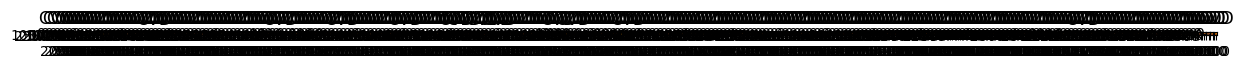

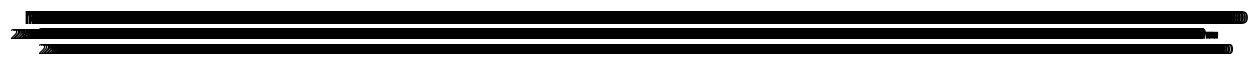

In [ ]:
plot_any(cvd, 'CVD')
plot_any(notcvd, 'NotCVD')


In [ ]:
img_selected = cvd[1]

In [ ]:
elbow(img_selected, 6)

NameError: name 'img_selected' is not defined

In [ ]:
k_klusters = 5

In [ ]:
result_gray = d2Kmeans(rgb2gray(img_selected), k_klusters)
result_img = d2Kmeans(img_selected, k_klusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


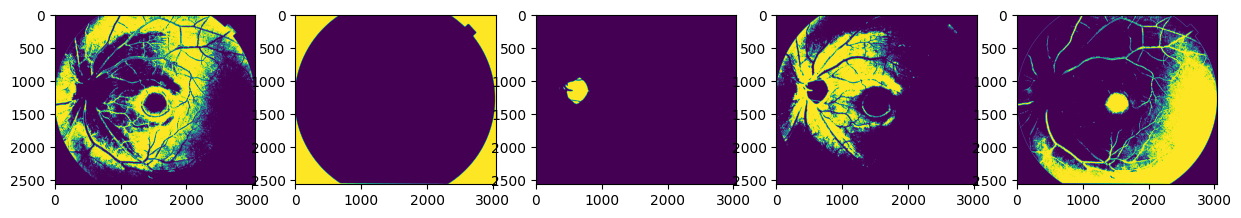

In [ ]:
klusters_gray = [result_gray == i for i in range(k_klusters)]
plot_any(klusters_gray)

In [ ]:
def select_cluster_index(clusters):
    minx = clusters[0].mean()
    index = 0
    for i in clusters:
        if i.mean() < minx:
            minx = i.mean()
            index += 1
    return index

In [ ]:
index_kluster = select_cluster_index(klusters_gray)
print(index_kluster)
selection = klusters_gray[index_kluster]

2


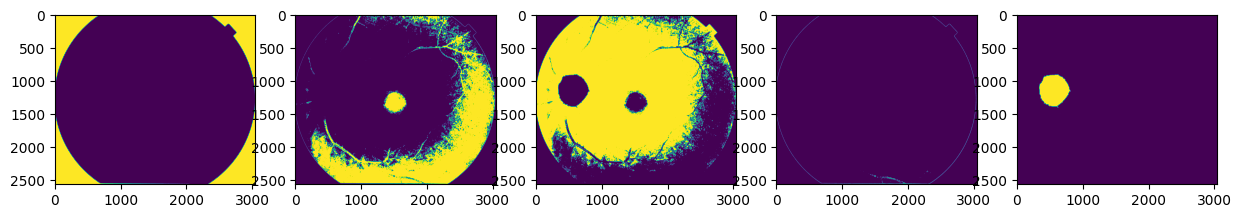

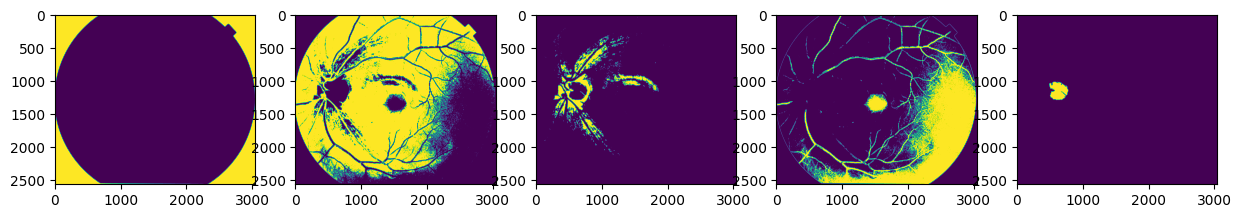

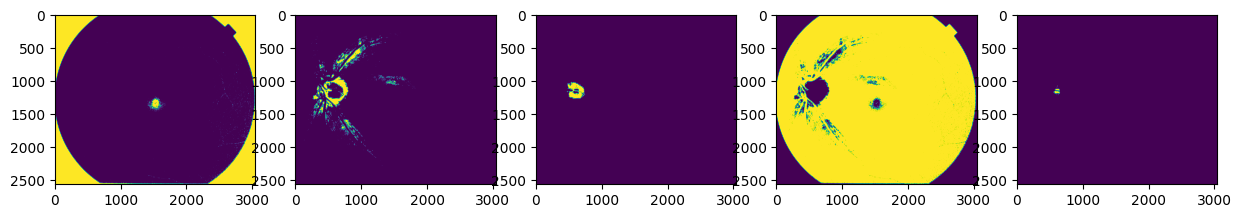

In [ ]:
for ch in range(3):
  img_k = []
  for K in range(k_klusters):
      img_k.append(result_img[:, :, ch] == K)
  plot_any(img_k)

In [ ]:
clusters = [(result_img[:,:,1] == K) for K in range(k_klusters)]

In [ ]:
clusters

[array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [ ]:
new_img = merge_segmented_mask_ROI(img_selected, selection)

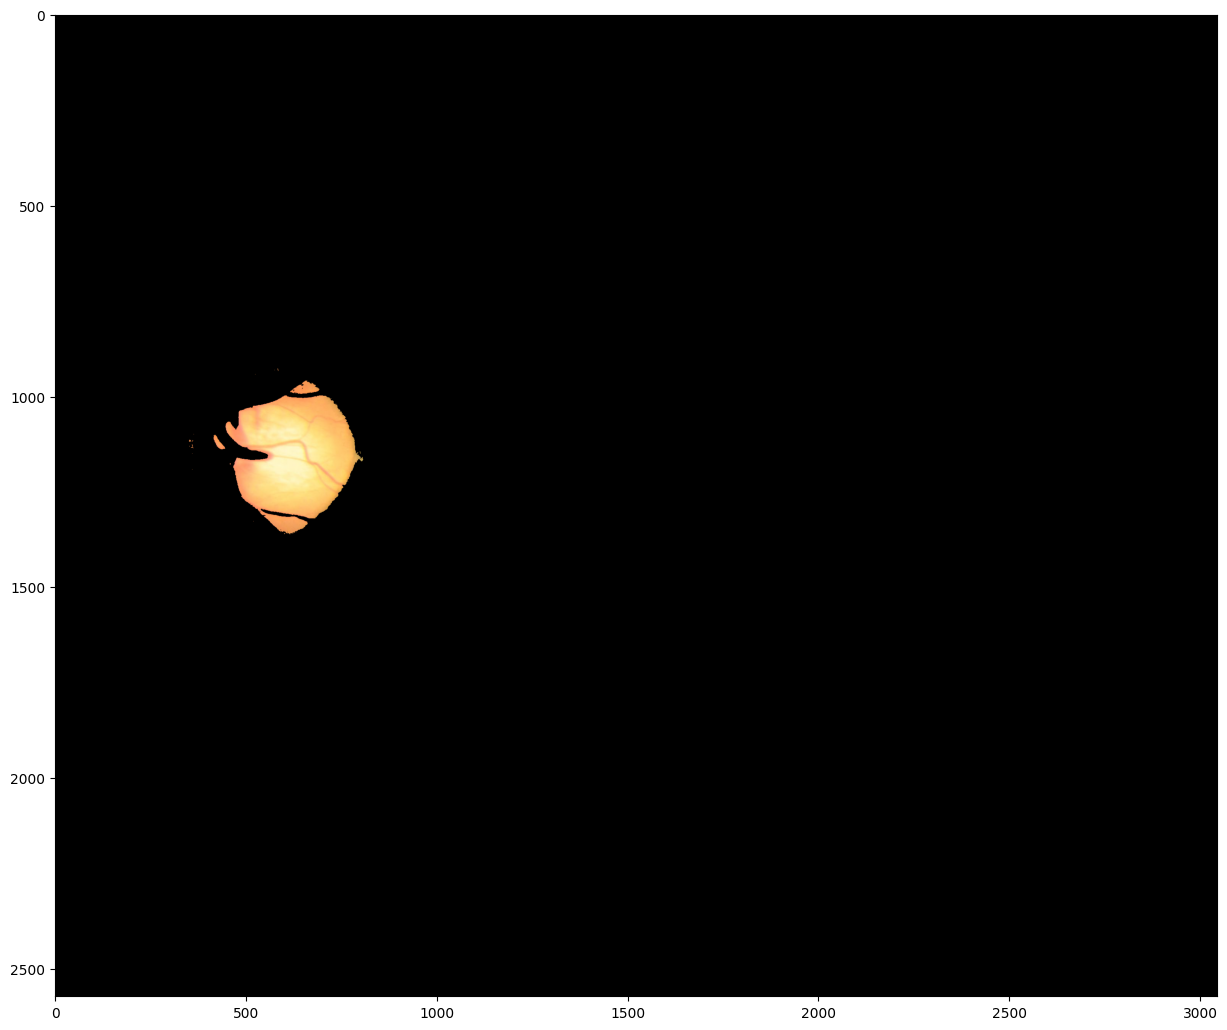

In [ ]:
plot_any([new_img])

In [ ]:
image_mean_filter = mean_filter(selection, 20)
test_binary = binary(image_mean_filter)

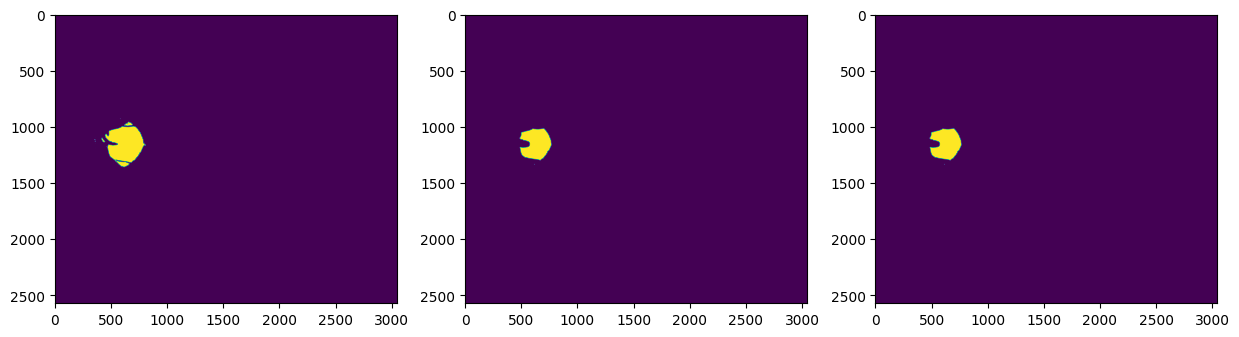

In [ ]:
plot_any([selection, image_mean_filter, test_binary])

In [ ]:
final_result = merge_segmented_mask_ROI(img_selected ,test_binary)

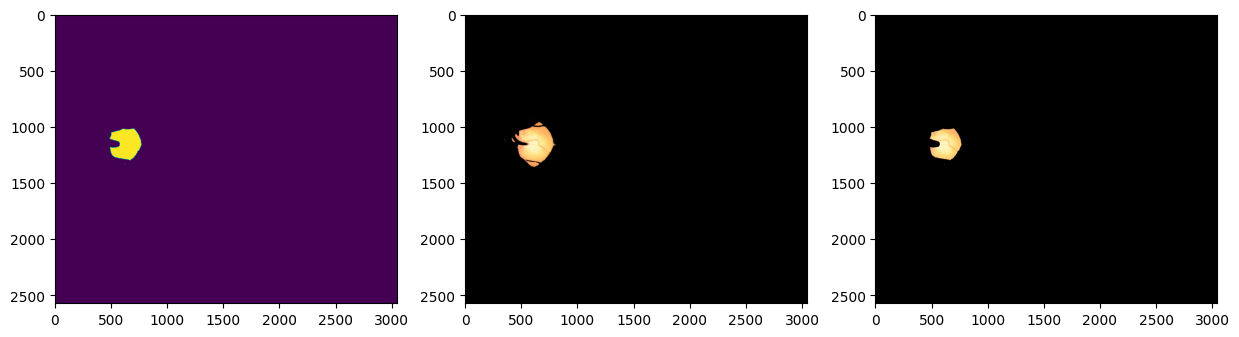

In [ ]:
plot_any([test_binary, new_img, final_result])

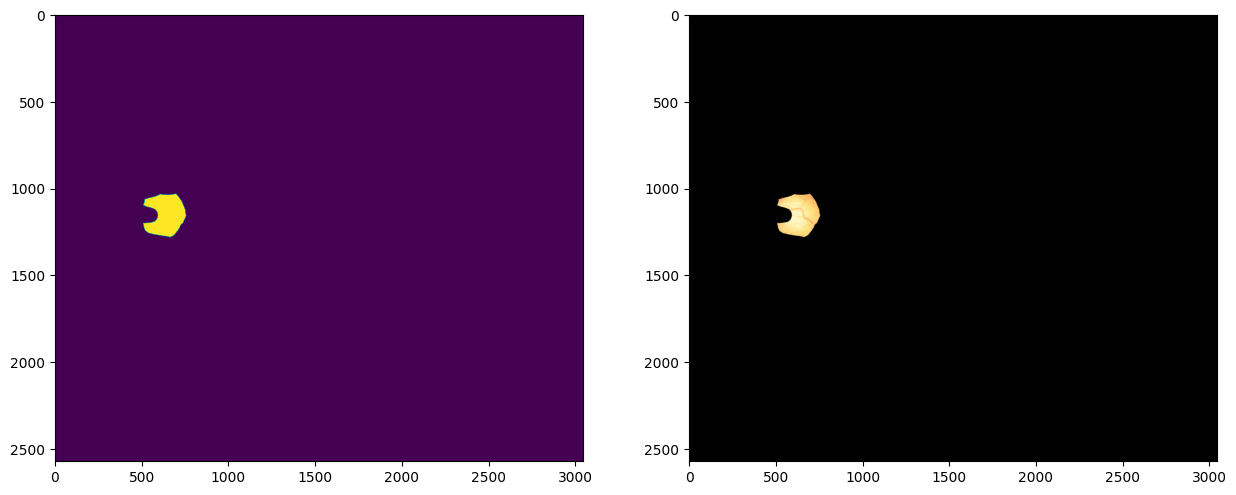

In [ ]:
max_mean = 0
img_gray = rgb2gray(final_result)
img_bin  = binary(img_gray)
x, y = img_bin.shape

limits_before = []
for i in range(x):
  for j in range(y):
    if  img_bin[i, j]:
      limits_before.append(j)

stop_before = ( sum(limits_before) // len(limits_before) ) // 2
img_copy = img_bin.copy()
for i in range(x):
    for j in range(stop_before):
        img_copy[i, j] = 0
        limits_after = []
for i in range(x):
     for j in range(y - 1, 0, -1):
        if  img_copy[i, j]:
            limits_after.append(j)

stop_after = sum(limits_after) // len(limits_after) + min(limits_after)
for i in range(x):
    for j in range(stop_after, y):
        img_copy[i, j] = 0

mean_result = mean_filter(img_copy, 15)
mean_result = binary(mean_result)
final_result = merge_segmented_mask_ROI(img_selected , mean_result)


plot_any([mean_result, final_result])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
img = cv2.imread(cvd_images[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()
#plotting
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
original_image = cv2.imread(cvd_images[1])
original_image


array([[[3, 2, 4],
        [3, 2, 4],
        [3, 2, 4],
        ...,
        [2, 1, 3],
        [2, 1, 3],
        [2, 1, 3]],

       [[3, 2, 4],
        [3, 2, 4],
        [3, 2, 4],
        ...,
        [2, 1, 3],
        [2, 1, 3],
        [2, 1, 3]],

       [[3, 2, 4],
        [3, 2, 4],
        [3, 2, 4],
        ...,
        [2, 1, 3],
        [2, 1, 3],
        [2, 1, 3]],

       ...,

       [[1, 0, 2],
        [2, 1, 3],
        [2, 1, 3],
        ...,
        [3, 3, 3],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 0, 2],
        [2, 1, 3],
        [2, 1, 3],
        ...,
        [3, 3, 3],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 0, 2],
        [2, 1, 3],
        [2, 1, 3],
        ...,
        [3, 3, 3],
        [1, 1, 1],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

In [ ]:
vectorized = img.reshape((-1,3))

In [ ]:
vectorized = np.float32(vectorized)

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [ ]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [ ]:
center = np.uint8(center)

In [ ]:
res = center[label.flatten()]
result_image = res.reshape((img.shape))

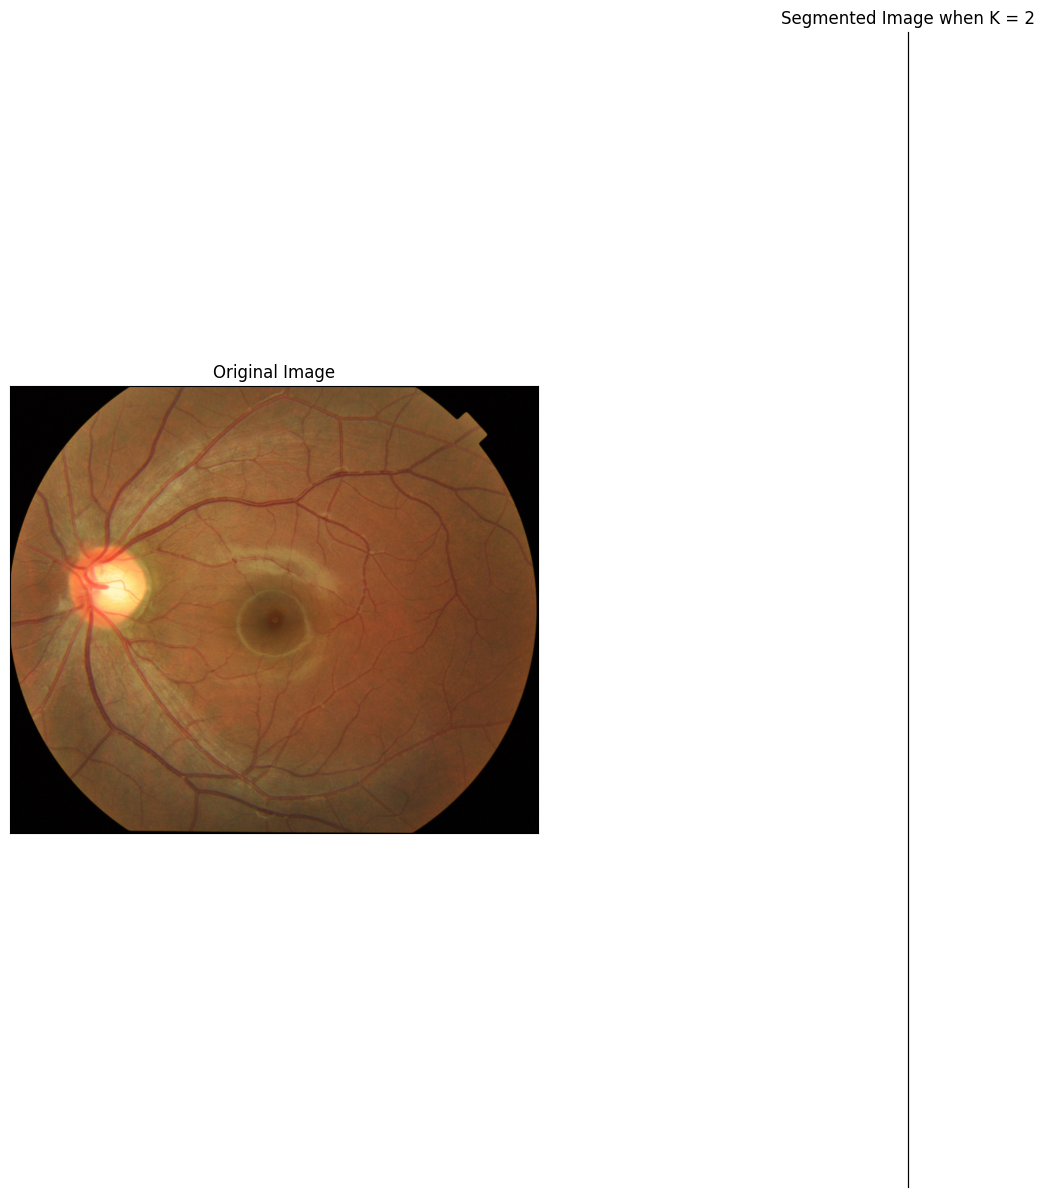

In [ ]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(res)
plt.title('Segmented Image when K = %i' % K)
plt.xticks([]), plt.yticks([])

plt.show()

1. K Means Clustering for Imagery Analysis

we will use a K-means algorithm to perform image classification. Clustering isn’t limited to the consumer information and population sciences, it can be used for imagery analysis as well. Leveraging Scikit-learn and the MNIST dataset, we will investigate the use of K-means clustering for computer vision.

In [ ]:
import sys
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

image = cv2.imread(cvd_images[2])
(h1, w1) = image.shape[:2]

image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

image = image.reshape((image.shape[0] * image.shape[1], 3))

clt = KMeans(n_clusters = 2)

labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]

#reshape the feature vectors to images
quant = quant.reshape((h1, w1, 3))
image = image.reshape((h1, w1, 3))

# convert from L*a*b* to RGB
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)



plt.imshow(quant)




NameError: name 'cvd_images' is not defined

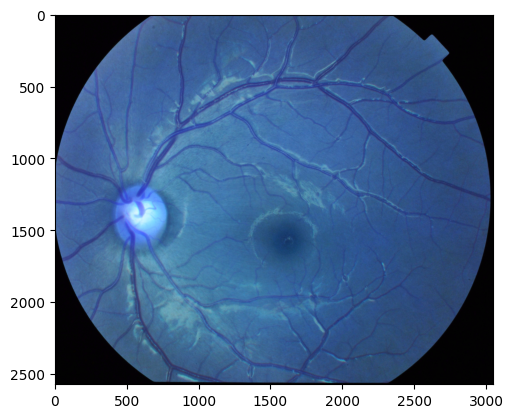

In [ ]:
plt.imshow(image)

In [ ]:
import pandas as pd
train_data =[]
for img in  cvd_images :
    train_data.append((img,0))

for img in notcvd_images :
    train_data.append((img,1))


train_data = pd.DataFrame(train_data, columns = ['image','label'] , index = None)
train_data['image'][0]
train_data

NameError: name 'cvd_images' is not defined

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Constants
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
DIRECTORY_PATH_CVD = "/content/CVD"
DIRECTORY_PATH_notCVD = "/content/NonCVD"

# Function to read images from a directory
def read_images_from_directory(directory_path, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(directory_path)):
        if filename.endswith(".JPG") or filename.endswith(".png"):
            image_path = os.path.join(directory_path, filename)
            img = cv2.imread(image_path)
            if isinstance(img, type(None)):
                continue
            elif img.shape[0] >= IMAGE_HEIGHT and img.shape[1] >= IMAGE_WIDTH:
                resized_img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
                images.append(resized_img.flatten())  # Reshape image into 1D array
                labels.append(label)
            else:
                continue
    return

#Read images and labels from CVD directory
images_cvd, labels_cvd = read_images_from_directory(DIRECTORY_PATH_CVD,1)

#Read images and labels from notCVD directory
images_notcvd, labels_notcvd = read_images_from_directory(DIRECTORY_PATH_notCVD,0)

# Combine images and labels
images = np.array(images_cvd + images_notcvd)
labels = np.array(labels_cvd + labels_notcvd)

# Create DataFrame
data = pd.DataFrame({"Image": images.tolist(), "Label": labels})

# Display first few rows of the DataFrame
print(data.head())


100%|██████████| 297/297 [00:27<00:00, 10.96it/s]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
import tensorflow as tf

# Assuming you have your data loaded into X and Y arrays
# X should be the images, and Y should be the corresponding labels
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
DIRECTORY_PATH_CVD = "/content/drive/MyDrive/1000images(changed)/CVD"
DIRECTORY_PATH_notCVD = "/content/drive/MyDrive/1000images(changed)/NotCVD"

X = []
Y = []

# # Function to read images from a directory
def read_images_from_directory(directory_path, label):
     for filename in tqdm(os.listdir(directory_path)):
         if filename.endswith(".JPG") or filename.endswith(".png"):
             image_path = os.path.join(directory_path, filename)
             img = cv2.imread(image_path)
             if isinstance(img, type(None)):
                 continue
             elif img.shape[0] >= IMAGE_HEIGHT and img.shape[1] >= IMAGE_WIDTH:
                 resized_img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
                 X.append(resized_img)
                 Y.append(label)
             else:
                 continue

# # Read images from subdirectories
read_images_from_directory(DIRECTORY_PATH_CVD, 1)  # Label 1 for CVD class
read_images_from_directory(DIRECTORY_PATH_notCVD, 0)  # Label 0 for notCVD class

# Save the data
np.save("X224.npy", X)
np.save("Y224.npy", Y)

# Load the data
X = np.load("X224.npy")
Y = np.load("Y224.npy")

# Convert the list of tensors into arrays
X = np.array(X)
Y = np.array(Y)
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer, sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

In [ ]:
model.save('/content/my_model.h5')
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 6s 837ms/step - loss: 0.6354 - accuracy: 0.7387
Test accuracy: 0.7386934757232666


1/1 [==============================] - 0s 201ms/step
Predictions:
[[0.35213414]]


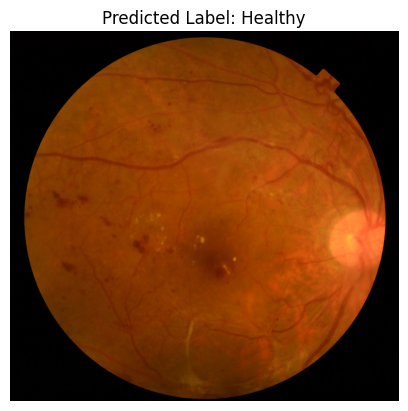

In [ ]:
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model('/content/my_model.h5')

# Function to preprocess input data
image_path = '/content/drive/MyDrive/1000images(changed)/CVD/1ffa9334-8d87-11e8-9daf-6045cb817f5b..JPG'  # Replace 'path_to_your_image.jpg' with the actual path
image = cv2.imread(image_path)
# Resize the image to the same size used during training
resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

# Normalize the image
normalized_image = resized_image / 255.0  # Assuming the images were normalized during training

# Reshape the image to match the input shape of the model
input_image = np.expand_dims(normalized_image, axis=0)
input_data = np.array(input_image)

predictions = model.predict(input_data)

# Print the predictions
print("Predictions:")
print(predictions)
# Get the predicted label
predicted_label = "Healthy" if predictions < 0.4153 else "Cardiovascular Disease"

# Display the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Predicted Label: " + predicted_label)
plt.axis('off')
plt.show()
